In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline  

In [317]:
img = cv2.imread('digits.png',0)

In [319]:
cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]

In [324]:
train_cells = [ i[:50] for i in cells ]
test_cells = [ i[50:] for i in cells]

In [327]:
np.array(train_cells).shape

(50, 50, 20, 20)

In [340]:
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed. 
        return img.copy()
    # Calculate skew based on central momemts. 
    skew = m['mu11']/m['mu02']
    # Calculate affine transform to correct skewness. 
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    # Apply affine transform
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

winSize = (20,20)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradients = True
 
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)

descriptor = hog.compute(im)

# Set up SVM for OpenCV 3
svm = cv2.ml.SVM_create()
# Set SVM type
svm.setType(cv2.ml.SVM_C_SVC)
# Set SVM Kernel to Radial Basis Function (RBF) 
svm.setKernel(cv2.ml.SVM_RBF)
# Set parameter C
svm.setC(C)
# Set parameter Gamma
svm.setGamma(gamma)
 
# Train SVM on training data  
svm.trainAuto(trainData, cv2.ml.ROW_SAMPLE, trainLabels)
 
# Save trained model 
svm.save("digits_svm_model.yml");
 
# Test on a held out test set
testResponse = svm.predict(testData)[1].ravel()

NameError: name 'im' is not defined

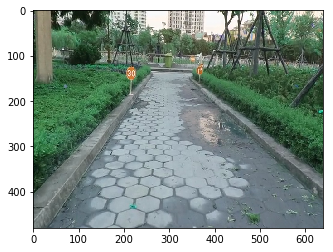

In [304]:
cap = cv2.VideoCapture('./source/Videos/MVI_1049.avi')
count = 0
while count < 302:
    ret, frame = cap.read()
    count += 1
plt.imshow(frame)

In [305]:
print(cap.get(cv2.CAP_PROP_FPS))

59.94005994005994


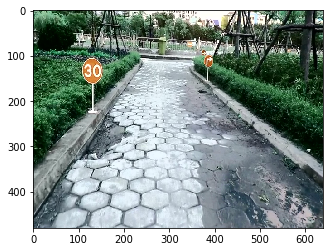

In [302]:
frame_1 =  constrastLimit(frame)
plt.imshow(frame_1)

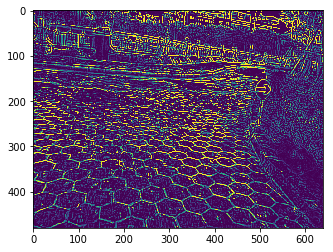

In [292]:
frame_2 = LaplacianOfGaussian(frame_1)
plt.imshow(frame_2)

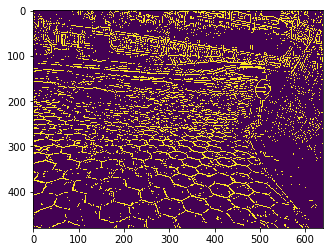

In [293]:
frame_3 = binarization(frame_2)
plt.imshow(frame_3)

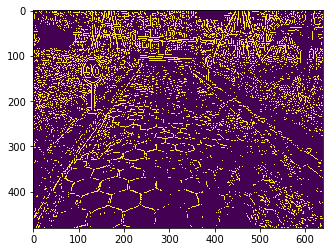

In [280]:
frame_3 = binarization(frame_2)
plt.imshow(frame_3)

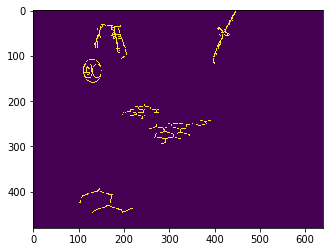

In [303]:
p_img = preprocess_image(frame_1)
p_img = removeSmallComponents(p_img,300)
plt.imshow(p_img)

In [279]:
### Preprocess image
def constrastLimit(image):
	img_hist_equalized = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
	channels = cv2.split(img_hist_equalized)
	channels[0] = cv2.equalizeHist(channels[0])
	img_hist_equalized = cv2.merge(channels)
	img_hist_equalized = cv2.cvtColor(img_hist_equalized, cv2.COLOR_YCrCb2BGR)
	return img_hist_equalized

def LaplacianOfGaussian(image):
	LoG_image = cv2.GaussianBlur(image, (3,3), 0)           # paramter 
	gray = cv2.cvtColor( LoG_image, cv2.COLOR_BGR2GRAY)
	LoG_image = cv2.Laplacian( gray, cv2.CV_8U,3,3,2)       # parameter
	LoG_image = cv2.convertScaleAbs(LoG_image)
	return LoG_image
	
def binarization(image):
	thresh = cv2.threshold(image,96,255,cv2.THRESH_BINARY)[1]
    #thresh = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
	return thresh

def preprocess_image(image):
	image = constrastLimit(image)
	image = LaplacianOfGaussian(image)
	image = binarization(image)
	return image

# Find Signs
def removeSmallComponents(image, threshold):
	#find all your connected components (white blobs in your image)
	nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
	sizes = stats[1:, -1]; nb_components = nb_components - 1

	img2 = np.zeros((output.shape),dtype = np.uint8)
	#for every component in the image, you keep it only if it's above threshold
	for i in range(0, nb_components):
	    if sizes[i] >= threshold:
	        img2[output == i + 1] = 255
	return img2

def findContour(image):
	#find contours in the thresholded image
	cnts = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE	)
	cnts = cnts[0] if imutils.is_cv2() else cnts[1]
	return cnts

def contourIsSign(perimeter, centroid, threshold):
	#  perimeter, centroid, threshold
	# # Compute signature of contour
	result=[]
	for p in perimeter:
		p = p[0]
		distance = sqrt((p[0] - centroid[0])**2 + (p[1] - centroid[1])**2)
		result.append(distance)
	max_value = max(result)
	signature = [float(dist) / max_value for dist in result ]
	# Check signature of contour.
	temp = sum((1 - s) for s in signature)
	temp = temp / len(signature)
	if temp < threshold: # is  the sign
		return True, max_value
	else: 				# is not the sign
		return False, max_value

#crop sign 
def cropContour(image, center, max_distance):
	width = image.shape[1]
	height = image.shape[0]
	top = max([int(center[0] - max_distance), 0])
	bottom = min([int(center[0] + max_distance + 1), width-1])
	left = max([int(center[1] - max_distance), 0])
	right = min([int(center[1] + max_distance+1), height-1])
	return image[left:right, top:bottom]

def findSigns(image, contours, threshold):
	signs = []
	for c in contours:
		# compute the center of the contour
		M = cv2.moments(c)
		if M["m00"] == 0:
			continue
		cX = int(M["m10"] / M["m00"])
		cY = int(M["m01"] / M["m00"])
		is_sign, max_distance = contourIsSign(c, [cX, cY], 1-threshold)
		if is_sign:
			sign = cropContour(image, [cX, cY], max_distance)
			signs.append(sign)
        
	return signs

def localization(image, min_size_components, similitary_contour_with_circle):
	binary_image = preprocess_image(image)
	cv2.imwrite('A.png', binary_image)
	binary_image = removeSmallComponents(binary_image, min_size_components)
	cv2.imwrite('B.png', binary_image)
	contours = findContour(binary_image)
	signs = findSigns(image, contours, similitary_contour_with_circle)
	return signs

def showsigns(signs, count):
	c = 0
	for s in signs:
		cv2.imwrite('result'+str(count)+'_'+str(c)+'.png', s)
		c = c + 1

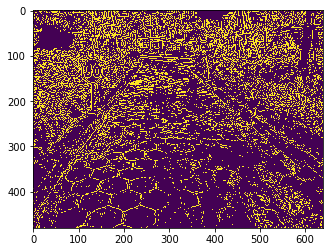

In [222]:
plt.imshow(preprocess_image(frame))

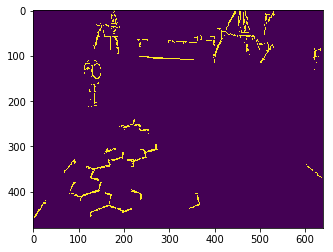

In [241]:
p_img = preprocess_image(frame_1)
p_img = removeSmallComponents(p_img,100)
plt.imshow(p_img)